##Import Modules


In [0]:
import functools
import time
import PIL.Image
import numpy as np

import tensorflow_hub as hub
import tensorflow as tf

import IPython.display as display

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12, 12)
mpl.rcParams['axes.grid'] = False

#Utility Functions


In [0]:
def tensor_to_image(tensor):
  '''
  Return a tensor as an image
  '''
  tensor = tensor*255
  tensor = np.array(tensor, dtype=np.uint8)
  if np.ndim(tensor) > 3:
      assert tensor.shape[0] == 1
      tensor = tensor[0]
  return PIL.Image.fromarray(tensor)


def load_img(path_to_img):
    """
    Loads an image and limit dimension size to 512px
    """
    max_dim = 512
    img = tf.io.read_file(path_to_img)
    img = tf.image.decode_image(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)

    shape = tf.cast(tf.shape(img)[:-1], tf.float32)
    long_dim = max(shape)
    scale = max_dim / long_dim

    new_shape = tf.cast(shape * scale, tf.int32)

    img = tf.image.resize(img, new_shape)
    img = img[tf.newaxis, :]

    return img


def imshow(image, title=None):
    """
    function displays an image
    """
    if len(image.shape) > 3:
        image = tf.squeeze(image, axis=0)

    plt.imshow(image)
    plt.show()

    if title:
        plt.title(title)


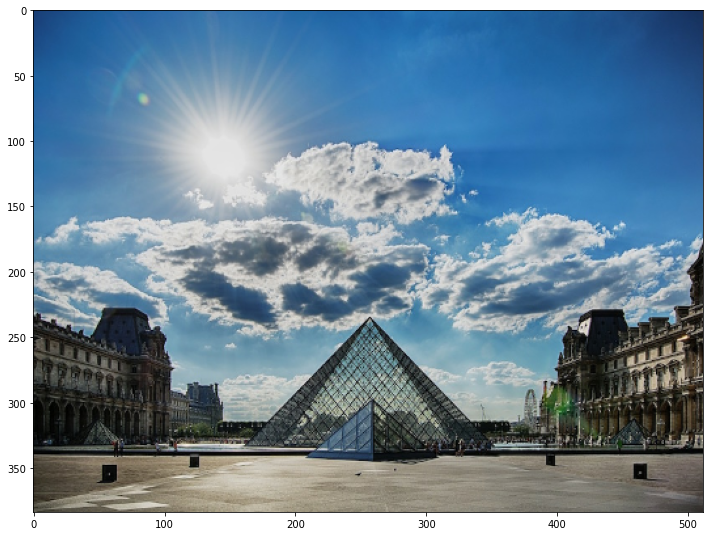

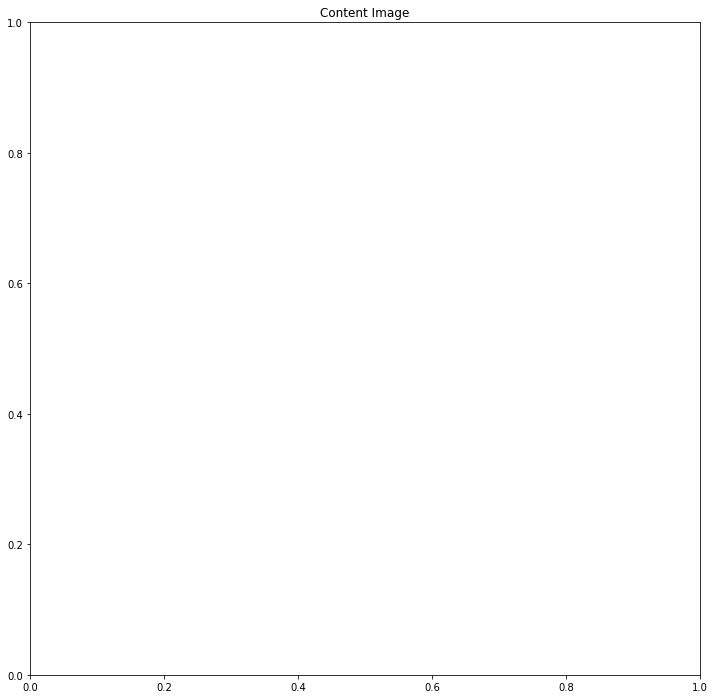

In [0]:
style_image = load_img('/starry_night.jpg')
content_image = load_img('/louvre.jpg')
plt.plot(1, 2, 1)
imshow(content_image, 'Content Image')

##Define content and style representation - using VGG19 architecture, pretrained on imagenet
```
Download the VGG-19 model weights from tf
```

In [0]:
# Scale content image by 255 (for color channel?)
x = tf.keras.applications.vgg19.preprocess_input(content_image*255)
# image resize to fit input size
x = tf.image.resize(x, (224, 224))

# Extract weights of model
vgg = tf.keras.applications.VGG19(include_top=True, weights='imagenet')
prediction_probabilities = vgg(x)
prediction_probabilities.shape

# Decode top-5 predictions to imagenet classes
predicted_top_5 = tf.keras.applications.vgg19.decode_predictions(prediction_probabilities.numpy())[0]
[(class_name, prob) for (number, class_name, prob) in predicted_top_5]


40960/35363 [==================================] - 0s 0us/step


[('palace', 0.36000785),
 ('suspension_bridge', 0.2219311),
 ('castle', 0.098546706),
 ('monastery', 0.07115037),
 ('pier', 0.056870054)]

Load a VGG-19 model without the last layer (classification layer)


In [0]:
# VGG-19 without classification
vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')

# print layers
print()
for layer in vgg.layers:
  print(layer.name)

80142336/80134624 [==============================] - 1s 0us/step

input_2
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


Choose an intermediate layer to represent content image. One layer is enough.


Choose several different layers to capture style, can get better results if we merge the style cost from different layers with weights

$$J_{style}(S,G) = \sum_{l} \lambda^{[l]} J^{[l]}_{style}(S,G)$$
where the values for $\lambda^{[l]}$ are given in `STYLE_LAYERS`. 

In [0]:
content_layers = ['block5_conv2'] 

style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1']
                
num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

## Build the model

In [0]:
def vgg_layers(layer_names):
  '''
  INPUT: a list of layer names
  OUTPUT: a model(functional object: input, output) that returns a list,
          specifically the output for each layer in layer_names
  function returns a vgg19 model that return output of layer_name - model requires input, 
  '''
  # grabs the pretrained model, remove classification layer, and freeze the weights
  vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
  vgg.trainable = False
  
  # store each layer's output to list 
  outputs = [vgg.get_layer(name).output for name in layer_names]

  # model = Model(inputs, outputs)
  model = tf.keras.Model([vgg.input], outputs)
  return model

## Create model

In [0]:
# create a vgg model that outputs the style layers
style_representation = vgg_layers(style_layers)
# Feed style image to the model
style_outputs = style_representation(style_image*255)

# OPTIONAL - Looks at statistic from each layer output
# output.shape - (m, width, height, num_of_filter/channels)
for name, output in zip(style_layers, style_outputs):
  print(name)
  print("  shape: ", output.numpy().shape)
  print("  min: ", output.numpy().min())
  print("  max: ", output.numpy().max())
  print("  mean: ", output.numpy().mean())
  print()

block1_conv1
  shape:  (1, 405, 512, 64)
  min:  0.0
  max:  673.43005
  mean:  23.779352

block2_conv1
  shape:  (1, 202, 256, 128)
  min:  0.0
  max:  2831.3438
  mean:  146.8449

block3_conv1
  shape:  (1, 101, 128, 256)
  min:  0.0
  max:  7256.615
  mean:  141.31274

block4_conv1
  shape:  (1, 50, 64, 512)
  min:  0.0
  max:  16345.258
  mean:  554.7913

block5_conv1
  shape:  (1, 25, 32, 512)
  min:  0.0
  max:  3919.4275
  mean:  47.456856



## Calculate Style
Style is calculated using Gram's matrix. 

**GOAL**: minimize the distance between the Gram matrix of style_image and generate_image

**IDEA**: Gram matrix calculates the correlation between filters/channels (i,j) in a layer



In [0]:
def gram_matrix(input_tensor):
  '''
  INPUT: input_tensor
  OUTPUT: the 
  '''
  # computes the element-wise sum of input tensor
  result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
  input_shape = tf.shape(input_tensor)
  num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
  return result/(num_locations)

##Extract Style and content
returns the style and content tensor

In [0]:
# define a VGG-model class that handles style and content layers 
class StyleContentModel(tf.keras.models.Model):
  def __init__(self, style_layers, content_layers):
    super(StyleContentModel, self).__init__()
    self.vgg =  vgg_layers(style_layers + content_layers)
    self.style_layers = style_layers
    self.content_layers = content_layers
    self.num_style_layers = len(style_layers)
    self.vgg.trainable = False
  
  # call Class Method
  def call(self, inputs):
    '''
    INPUT: image 
    OUTPUT: dictionary of dictionaries with content&style layer:output
    '''
    inputs = inputs*255.0
    preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
    # vgg model output
    outputs = self.vgg(preprocessed_input)
    style_outputs, content_outputs = (outputs[:self.num_style_layers], 
                                      outputs[self.num_style_layers:])
    # calculate gram matrix of style_layers
    style_outputs = [gram_matrix(style_output)
                     for style_output in style_outputs]
    # Store content and style outputs in dictionary
    content_dict = {content_name:value 
                    for content_name, value 
                    in zip(self.content_layers, content_outputs)}

    style_dict = {style_name:value
                  for style_name, value
                  in zip(self.style_layers, style_outputs)}
    
    return {'content':content_dict, 'style':style_dict}

1. Initialize model instance by providing input_layers - model will return output from specified input_layers

2. Provide input_image to model - model will return the outputs of layers specified in step 1 for input_image

In [0]:
# Create class instance
extractor = StyleContentModel(style_layers, content_layers)
# calls class instance with image input
results = extractor(tf.constant(content_image))

# Iterate through the style dictionary in results to print 
# layer and its corresponding output
print('Styles:')
for name, output in sorted(results['style'].items()):
  print("  ", name)
  print("    shape: ", output.numpy().shape)
  print("    min: ", output.numpy().min())
  print("    max: ", output.numpy().max())
  print("    mean: ", output.numpy().mean())
  print()

print("Contents:")
for name, output in sorted(results['content'].items()):
  print("  ", name)
  print("    shape: ", output.numpy().shape)
  print("    min: ", output.numpy().min())
  print("    max: ", output.numpy().max())
  print("    mean: ", output.numpy().mean())

Styles:
   block1_conv1
    shape:  (1, 64, 64)
    min:  0.052200288
    max:  18659.148
    mean:  716.95667

   block2_conv1
    shape:  (1, 128, 128)
    min:  0.0
    max:  101336.56
    mean:  16400.799

   block3_conv1
    shape:  (1, 256, 256)
    min:  2.5124779
    max:  316713.88
    mean:  13793.091

   block4_conv1
    shape:  (1, 512, 512)
    min:  0.0
    max:  5037207.5
    mean:  190961.0

   block5_conv1
    shape:  (1, 512, 512)
    min:  0.0
    max:  113136.375
    mean:  1626.7269

Contents:
   block5_conv2
    shape:  (1, 24, 32, 512)
    min:  0.0
    max:  1098.3223
    mean:  14.550507


##Run Gradient Descend to minimize cost function

calculate mean-square-error for output relative to targets

In [0]:
# Set Gram matrices of the StyleImage as target for minimization
# (so each gradient descend algorithm can learn the "style")
style_target = extractor(style_image)['style']

# Set VGG model's intermediate layer output of ContentImage as target
# (so GD can generate image with abstracted features from ContentImage)
content_target = extractor(content_image)['content']

# Define image to optimize
generated_image = tf.Variable(content_image)

def clip_0_1(image):
  '''
  clips image so pixel values remains between (0,1)
  '''
  return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)


## Compile model with optimizer
Follow the suggested hyperparameter in the paper


In [0]:
opt = tf.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)

##Define weight parameters for the two loss functions

$$J(G) = \alpha J_{content}(C,G) + \beta J_{style}(S,G)$$

In [0]:
style_weight=1e-2
content_weight=1e4

# Loss function: linear combination of style and content loss
def style_content_loss(outputs):
  '''
  INPUT: output = model(image)
  '''
  style_output = outputs['style']
  content_output = outputs['content']
  
  # store style mean-square-error across layers then sum values in list to get 
  # total style loss
  # tf.add_n() - add all input tensors element-wise
  # tf.reduce_mean() - 1/m * summation(...)
  style_loss = tf.add_n([tf.reduce_mean((style_output[name]-style_target[name])**2)
                              for name in style_output.keys()])
  style_loss *= style_weight / num_style_layers
  
  content_loss = tf.add_n([tf.reduce_mean((content_output[name]-content_target[name])**2) 
                             for name in content_output.keys()])
  content_loss *= content_weight / num_content_layers
  
  loss = style_loss + content_loss
  return loss

**Boilerplate code**
For one iteration of gradient descend


In [0]:
# @tf.function()
def train_step(image):
  '''
  One training step (one iteration of gradient descend)
  '''
  with tf.GradientTape() as tape:
    outputs = extractor(image)
    loss = style_content_loss(outputs)

  # calculates gradients based on loss?
  grad = tape.gradient(loss, image)
  # apply gradients to optimization algorithm for iamge update
  opt.apply_gradients([(grad, image)])
  image.assign(clip_0_1(image))

## Run 3 iterations of gradient descend to see the effects on the generated image

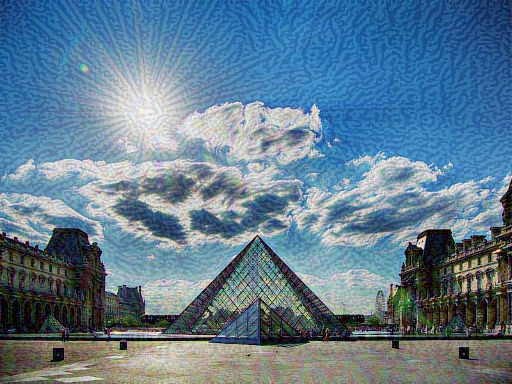

In [0]:
train_step(generated_image)
train_step(generated_image)
train_step(generated_image)
tensor_to_image(generated_image)

##Perform full optimization with 10 epochs, each epoch train on the image 100 times 
**Boilerplate code**

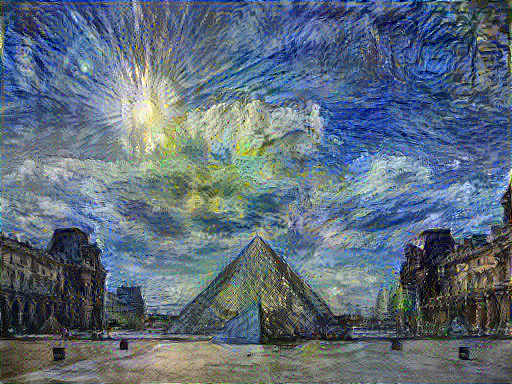

Train step: 1000
Total time: 125.8


In [0]:
import time
start = time.time()

epochs = 10
steps_per_epoch = 100

step = 0
# train for 10 epoch
for n in range(epochs):
  # for each epoch perform 100 gradient descend steps
  for m in range(steps_per_epoch):
    step += 1
    train_step(generated_image)
    print(".", end='')
  display.clear_output(wait=True)
  display.display(tensor_to_image(generated_image))
  print("Train step: {}".format(step))
  
end = time.time()
print("Total time: {:.1f}".format(end-start))

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
